In [2]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32,

)


Found 4752 files belonging to 9 classes.


In [5]:
class_names = sorted(os.listdir(data_path))  # Get folder names
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [6]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),   # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.4),         # Randomly rotate images by up to 20%
    RandomZoom(0.4),             # Randomly zoom into images by 20%
    RandomBrightness(factor=0.4),        # Randomly increase the brightness
    RandomCrop(150,160)
])


# Apply augmentation to the training data
def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



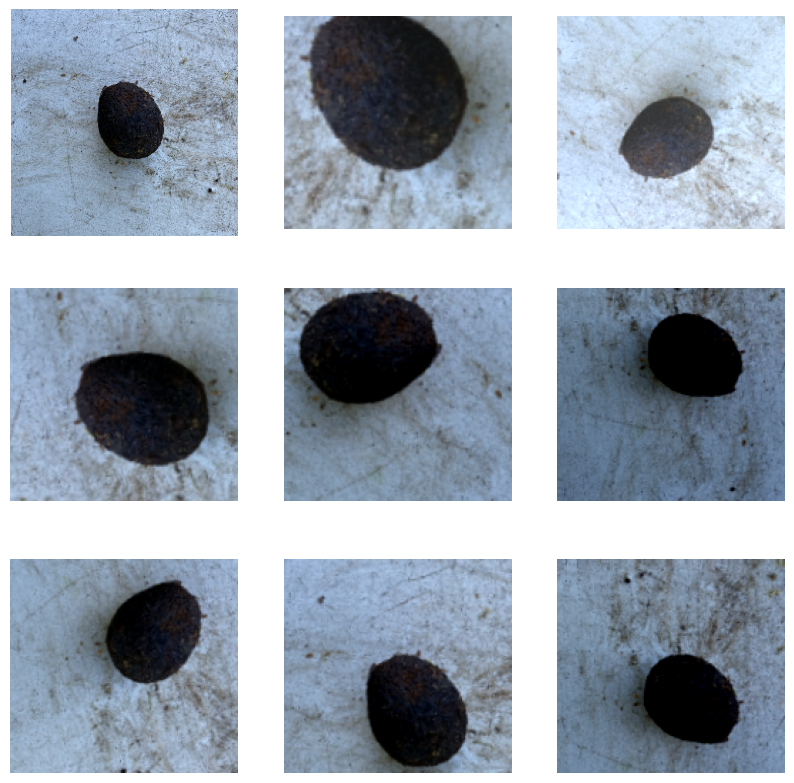

In [7]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]  # Select the first image in the batch

        # Apply augmentation multiple times to the same image
    augmented_images = [image]
    for _ in range(8):  # Create 8 augmented versions
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])

        # Display the original and augmented images
    for i in range(9):  # Display 9 images (1 original + 8 augmented)
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")

    plt.show()

# Call the function to visualize data augmentation
visualize_dataset(dataset, class_names)

In [8]:
def normalize_img(image, label):
    image = image/ 255.0  # Scale pixel values to [0, 1]
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label




In [9]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [10]:
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

train_dataset = dataset.take(train_size).map(augment).map(normalize_img)

val_dataset = dataset.skip(train_size).take(val_size).map(normalize_img)
test_dataset = dataset.skip(train_size + val_size).map(normalize_img)

In [11]:
for images, labels in train_dataset.take(1):
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")

Min pixel value: 0.0
Max pixel value: 1.0


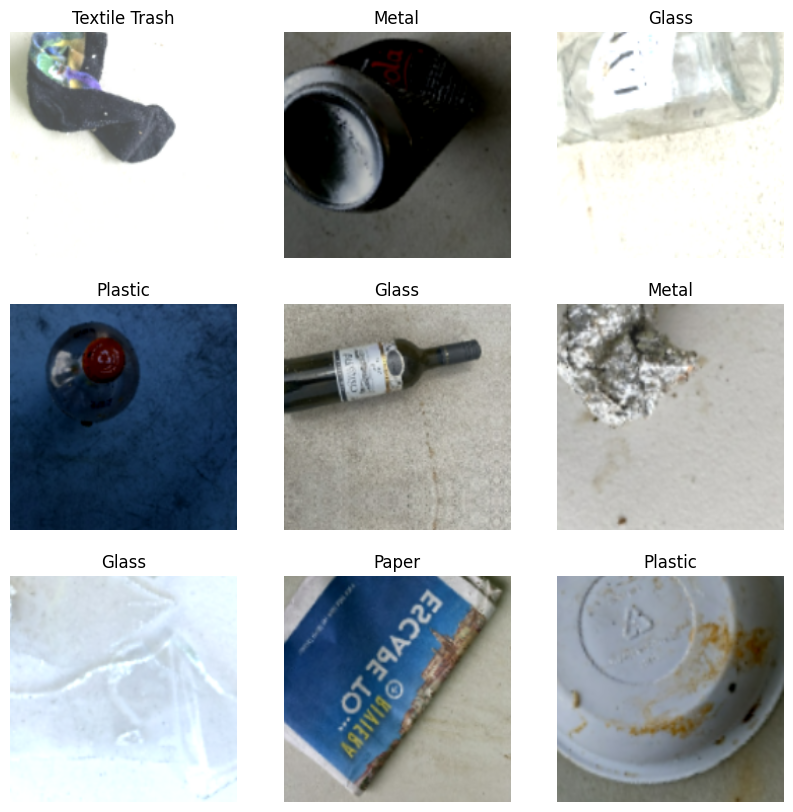

In [12]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Get one batch
        for i in range(9):  # Show 9 images
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()
            plt.imshow(img)
            label_idx = tf.argmax(labels[i]).numpy()  # Extract class index from one-hot label
            plt.title(class_names[label_idx])
            plt.axis("off")
    plt.show()

# Visualize data augmentation results
visualize_dataset(train_dataset, class_names)

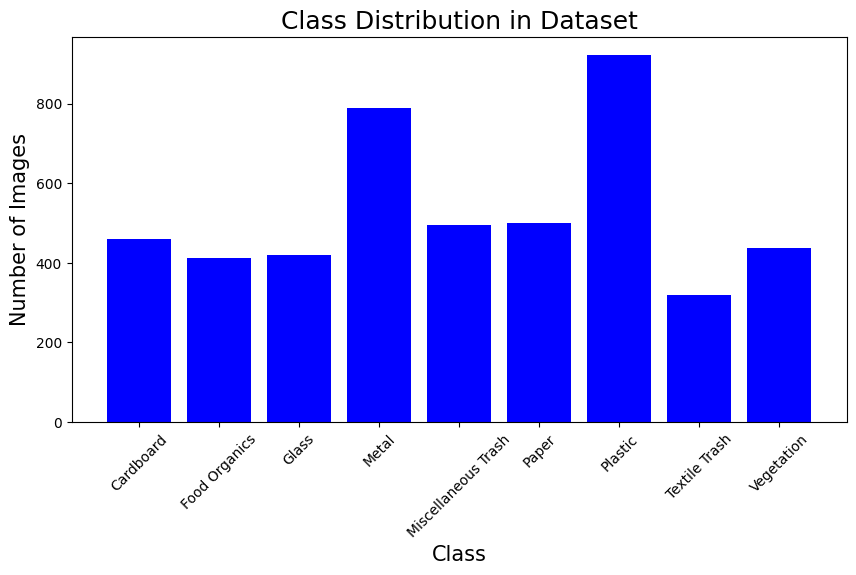

In [13]:


# Count number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [14]:
label_counter = Counter()
for _, label in train_dataset.unbatch().as_numpy_iterator():
    label = np.array(label)
    if label.size == 1:
        label = label.item()
    else:
        label = int(np.argmax(label))
    label_counter[int(label)] += 1

# Step 4: Identify underrepresented classes (e.g., below median)
counts = np.array(list(label_counter.values()))
median_count = np.median(counts)
low_classes = [cls for cls, count in label_counter.items() if count < median_count]
low_class_tensor = tf.constant(low_classes, dtype=tf.int64)
print("Low-frequency classes:", low_classes)

def is_low_class(image, label):
    label = tf.cast(tf.argmax(label, axis=-1), tf.int64)
    return tf.reduce_any(tf.equal(label, low_class_tensor))

def extra_augment(image, label):
    image = tf.image.rot90(image)
    image = tf.image.random_saturation(image, 0.6, 1.4)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.cast(label, tf.int32), 9)
    return image, label

low_class_augmented = train_dataset.unbatch().filter(is_low_class).map(extra_augment).map(normalize_img).repeat(3).batch(32)

# Step 6: Combine both into final training set


final_train_dataset = train_dataset.concatenate(low_class_augmented).unbatch().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)


Low-frequency classes: [2, 1, 7, 8]


In [15]:
print("Class distribution after final augmentation:")
label_counter = Counter()

for _, labels in final_train_dataset.unbatch().take(1000):
    label = labels.numpy()
    if label.shape == (9,):  # one-hot
        label_idx = np.argmax(label)
        label_counter[int(label_idx)] += 1

print(dict(label_counter))



Class distribution after final augmentation:
{3: 164, 1: 89, 2: 83, 6: 203, 7: 66, 0: 114, 4: 93, 5: 93, 8: 95}


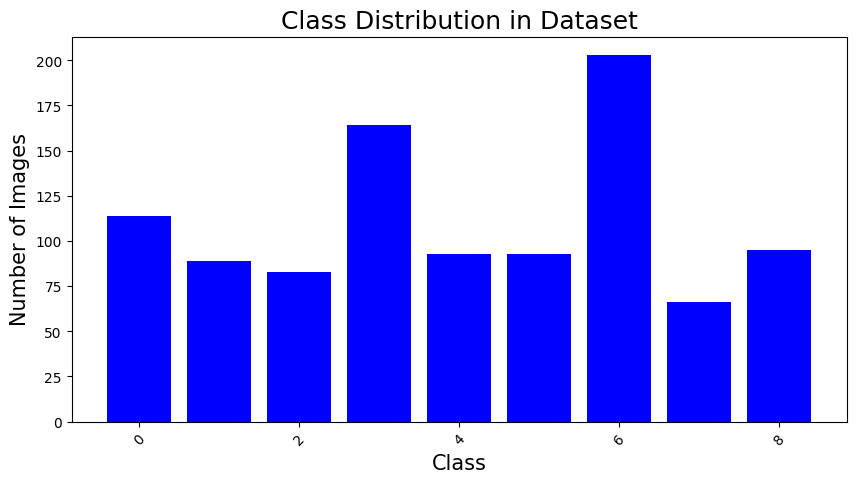

In [16]:


# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(label_counter.keys(), label_counter.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [17]:
# Class weights computation
train_labels = []
for _, label in final_train_dataset.unbatch().take(1000):  # Limit for speed/safety
    label = label.numpy()
    while label.ndim > 1:
        label = np.mean(label, axis=0)
    if label.ndim == 1 and label.shape[0] == 9:
        class_idx = int(np.argmax(label))
        train_labels.append(class_idx)

train_labels = np.array(train_labels)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.arange(9), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(1.019367991845056), 1: np.float64(1.2484394506866416), 2: np.float64(1.122334455667789), 3: np.float64(0.6574621959237343), 4: np.float64(1.1695906432748537), 5: np.float64(1.145475372279496), 6: np.float64(0.5555555555555556), 7: np.float64(1.8214936247723132), 8: np.float64(1.3717421124828533)}


In [18]:

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for multi-class classification with one-hot labels.
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

    return loss

In [29]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model



# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(9, activation="softmax")  # Adjust for the number of classes
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss",  # Monitor the validation loss
                               patience=3,  # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best model weights when stopping
                               verbose=1)  # Print messages when stopping

history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weights_dict, callbacks=[early_stopping])



Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 115s 884ms/step - accuracy: 0.1129 - loss: 2.4001 - val_accuracy: 0.0923 - val_loss: 2.2126
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 675ms/step - accuracy: 0.1233 - loss: 2.3403 - val_accuracy: 0.1832 - val_loss: 2.1972
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 678ms/step - accuracy: 0.1106 - loss: 2.3344 - val_accuracy: 0.1719 - val_loss: 2.1939
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 677ms/step - accuracy: 0.1051 - loss: 2.3528 - val_accuracy: 0.2344 - val_loss: 2.1924
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 667ms/step - accuracy: 0.1129 - loss: 2.2833 - val_accuracy: 0.1619 - val_loss: 2.1921
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 681ms/step - accuracy: 0.1121 - loss: 2.3226 - val_accuracy: 0.1278 - val_loss: 2.1942
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 67s 642ms/step - accuracy: 0.1158 - loss: 2.3023 - val_accuracy: 0.1435 - val_loss: 2.1962
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 86s 678ms/step - accuracy: 0.1078 - loss: 

In [31]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.72      0.50        71
           1       0.44      0.54      0.49        70
           2       0.43      0.05      0.09        59
           3       0.61      0.55      0.58        96
           4       0.31      0.33      0.32        72
           5       0.48      0.46      0.47        87
           6       0.55      0.26      0.36       125
           7       0.34      0.33      0.33        46
           8       0.52      0.85      0.65        78

    accuracy                           0.46       704
   macro avg       0.45      0.45      0.42       704
weighted avg       0.47      0.46      0.43       704



In [30]:
# Fine-tuning (optional)
base_model.trainable = True
for layer in base_model.layers[:20]:  # Freeze first 100 layers
    layer.trainable = True

# Recompile after unfreezing
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=["accuracy"])

# Train again on the small batch
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weights_dict, )

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 176s 895ms/step - accuracy: 0.1028 - loss: 2.8665 - val_accuracy: 0.1960 - val_loss: 2.2801
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 659ms/step - accuracy: 0.1495 - loss: 2.6164 - val_accuracy: 0.0980 - val_loss: 2.3730
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 703ms/step - accuracy: 0.1893 - loss: 2.4381 - val_accuracy: 0.1051 - val_loss: 2.6971
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 643ms/step - accuracy: 0.2312 - loss: 2.1991 - val_accuracy: 0.1349 - val_loss: 2.4991
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 87s 683ms/step - accuracy: 0.2681 - loss: 2.1315 - val_accuracy: 0.2855 - val_loss: 2.0079
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 702ms/step - accuracy: 0.3098 - loss: 1.9737 - val_accuracy: 0.2443 - val_loss: 2.0736
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 701ms/step - accuracy: 0.3426 - loss: 1.8755 - val_accuracy: 0.2628 - val_loss: 2.0241
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 653ms/step - accuracy: 0.3741 - loss: 

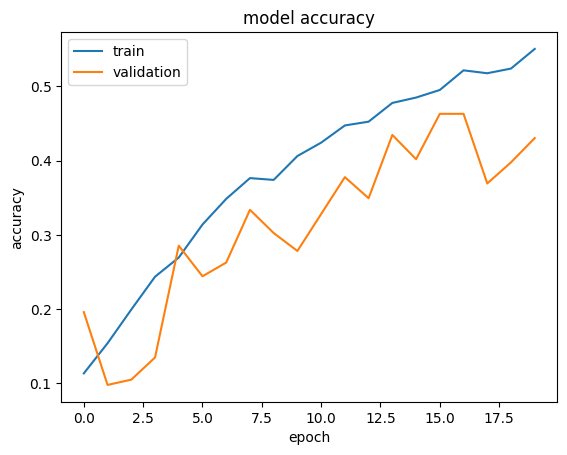

In [33]:
def plot_hist(history_fine_tune):
    plt.plot(history_fine_tune.history["accuracy"])
    plt.plot(history_fine_tune.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_fine_tune)

In [34]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [35]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.70      0.46        66
           1       0.43      0.57      0.49        67
           2       0.50      0.05      0.08        66
           3       0.59      0.54      0.56       109
           4       0.36      0.36      0.36        77
           5       0.47      0.48      0.47        73
           6       0.49      0.21      0.29       134
           7       0.45      0.50      0.47        46
           8       0.49      0.86      0.62        66

    accuracy                           0.45       704
   macro avg       0.46      0.47      0.43       704
weighted avg       0.47      0.45      0.42       704



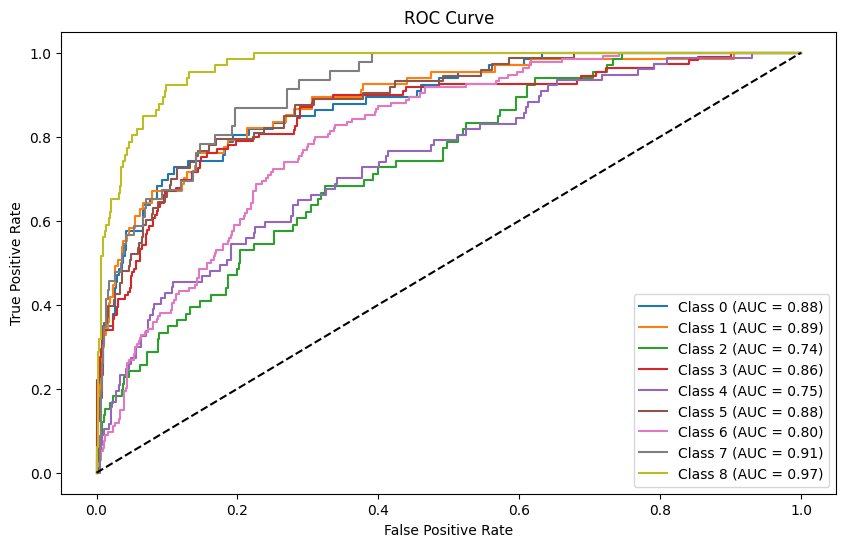

In [36]:

# Convert true labels to one-hot encoding
num_classes = 9  # Adjust to your number of classes
y_true_one_hot = to_categorical(y_true, num_classes)

# Plot ROC Curve for each class
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

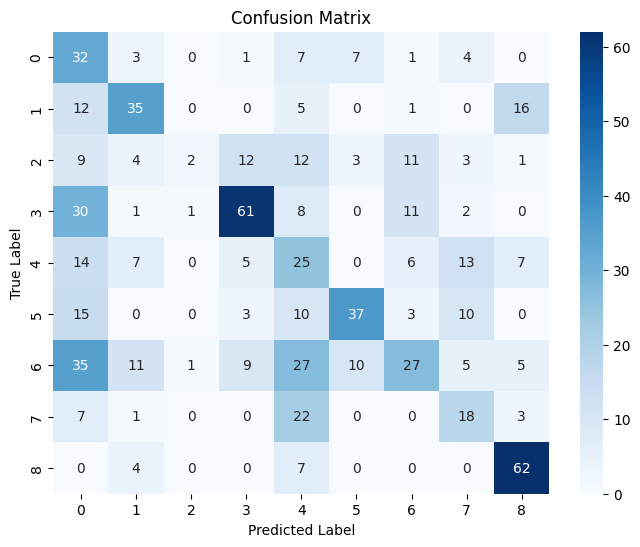

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
You said:
i applied augmentation on train dataset  Ensure eager execution is enabled
# tf.compat.v1.enable_eager_execution()

# Iterate over batches of the training dataset
train_labels = []

# Use .as_numpy_iterator() to convert the TensorFlow dataset to numpy
for batch in train_dataset.as_numpy_iterator():
    labels = batch[1]  # Extract the labels (second element of the batch)

    # If labels are one-hot encoded, convert to class indices
    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

    train_labels.extend(labels)  # Add the labels to the list

# Convert the list of labels into a numpy array
train_labels = np.array(train_labels)

# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print out class weights (for reference)
print("Class weights:", class_weights_dict) and I applied this weight     precision    recall  f1-score   support

           0       0.41      0.49      0.45        70
           1       0.54      0.64      0.58        55
           2       0.30      0.12      0.17        57
           3       0.50      0.62      0.55       117
           4       0.33      0.38      0.35        74
           5       0.49      0.57      0.53        76
           6       0.63      0.23      0.34       136
           7       0.28      0.48      0.35        54
           8       0.65      0.77      0.70        65

    accuracy                           0.46       704
   macro avg       0.46      0.48      0.45       704
weighted avg       0.48      0.46      0.45       704 base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model



# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(9, activation="softmax")  # Adjust for the number of classes
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss",  # Monitor the validation loss
                               patience=3,  # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best model weights when stopping
                               verbose=1)  # Print messages when stopping

# history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weights_dict, callbacks=[early_stopping])   what can I doo



ChatGPT said:
Thanks for the detailed context! From what you've shared, you're training an EfficientNetB0-based model with data augmentation and class weights to handle class imbalance. You're getting a moderate performance (~46% accuracy), with class 2 and class 6 performing poorly. Let's walk through potential improvements:

🔍 1. Class Imbalance Handling
You've already applied class_weight, which is good. But the metrics still show poor recall and precision for minority classes. Here’s how to push it further:

✅ Combine with Focal Loss (instead of categorical crossentropy)
Focal loss is great for class imbalance, especially when dominant classes overwhelm the minority.

python
Copy
Edit
!pip install keras-losses  # if needed

from keras.losses import categorical_focal_loss

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=categorical_focal_loss(alpha=1, gamma=2),
              metrics=["accuracy"])
Or define it manually if the import fails.

🧠 2. Unfreeze Base Model (Fine-Tuning)
Currently, base_model.trainable = False. Once top layers are trained for a few epochs, unfreeze EfficientNet layers for fine-tuning.

python
Copy
Edit
# After a few initial epochs
base_model.trainable = True
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
              loss="categorical_crossentropy",
              metrics=["accuracy"])
Then continue training with model.fit(...).

📈 3. Better Data Augmentation
You mentioned augmentation, but if it's simple (flip/rotate), consider adding more:

python
Copy
Edit
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1)
])
Apply this in your pipeline before feeding into base_model.

🧪 4. Evaluation Metrics (Per-Class F1 Monitoring)
Instead of just accuracy, add custom metrics or callbacks to monitor per-class F1. For instance, create a callback to track per-class recall during training.

🗂️ 5. Try Different Sampling Techniques
If your dataset is very imbalanced and class weight alone isn’t working, try:

Oversampling minority classes (via tf.data)

Undersampling majority classes

SMOTE (if data is not image or during embedding)

📉 6. Learning Rate Scheduling
Add ReduceLROnPlateau:

python
Copy
Edit
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
✅ 7. Confusion Matrix & Misclassification Review
Run a confusion matrix after prediction:

python
Copy
Edit
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(model.predict(val_dataset), axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
Identify which classes are getting misclassified into which others — can help you understand whether they’re similar visually.

🧪 Bonus: Try Mixup or CutMix
These augmentations work wonders for deep learning image tasks.

TL;DR - Try This Strategy:
Train initial model with class_weight + data augmentation.

Unfreeze base model and fine-tune with lower LR.

Try Focal Loss.

Use ReduceLROnPlateau + EarlyStopping.

Improve augmentations.

Evaluate misclassified classes.

Optional: try Mixup/CutMix or sample balancing.

Want help writing code for any of these? Or want to share a sample of the dataset or misclassified classes so we can dive deeper?







You said:
CNN.ipynb
File
this is the file


ChatGPT said:
It looks like the file wasn't saved properly on the system. Could you please try re-uploading the CNN.ipynb notebook? Once it's uploaded again, I’ll inspect the code and help you fine-tune it for better performance, class balance, and accuracy. ​​


3/3







You said:
              precision    recall  f1-score   support

           0       0.21      0.58      0.31        55
           1       0.53      0.51      0.52        69
           2       0.50      0.04      0.07        57
           3       0.67      0.54      0.60       114
           4       0.20      0.32      0.25        77
           5       0.65      0.47      0.55        78
           6       0.45      0.21      0.28       130
           7       0.33      0.35      0.34        51
           8       0.66      0.85      0.74        73

    accuracy                           0.42       704
   macro avg       0.47      0.43      0.41       704
weighted avg       0.49      0.42      0.42       704


ChatGPT said:
The metrics indicate that your model is struggling, especially with:

Class Imbalance: Some classes (like 2 and 6) have very low recall, indicating they are often misclassified.

Inconsistent Precision and Recall: Classes like 0, 2, and 6 have poor precision and recall, while class 8 is performing well.

Low F1-Score: Indicates that the model is not balanced between precision and recall.

🔧 Recommended Next Steps:
1. Switch to Focal Loss
Focal loss helps the model focus on hard-to-classify samples and reduces the impact of easily classified samples.

2. Data Augmentation Enhancements
Use advanced augmentation techniques to add more variety and robustness to the training data. Techniques like:

MixUp: Blends two images together.

CutMix: Mixes two images by cutting and pasting patches.

Random Erasing: Randomly removes parts of the image.

3. Weighted Loss Function
Instead of using class_weight, directly modify the loss function to integrate weights, making it more adaptive during training.

4. Unfreeze Some Layers for Fine-Tuning
Fine-tune the last few layers of EfficientNetB0 to better adapt to your specific dataset.

5. Learning Rate Scheduling
Use ReduceLROnPlateau to lower the learning rate when the validation loss plateaus.

6. Confusion Matrix and Error Analysis
Analyze the confusion matrix to understand which classes are being confused the most and investigate whether the issue is due to data quality or model limitations.

Would you like me to implement these changes and provide a revised training script for you?







You said:
How to do hyperparameter tuning


ChatGPT said:
Hyperparameter tuning is essential to optimize your model's performance. It involves systematically searching for the best combination of hyperparameters that minimize the loss function or maximize accuracy.

Here’s a breakdown of how you can perform hyperparameter tuning effectively:

🔑 1. Key Hyperparameters to Tune
Since you are working with a CNN (EfficientNetB0), here are some key hyperparameters to focus on:

Learning Rate: Controls how much to change the model in response to the estimated error.

Batch Size: Number of samples processed before updating the model.

Optimizer: Adam, SGD, RMSprop, etc.

Dropout Rate: Prevents overfitting by randomly dropping neurons.

Number of Neurons (Dense Layer): How many neurons in the dense layer after feature extraction.

Activation Functions: ReLU, LeakyReLU, etc.

Data Augmentation Parameters: Rotation, flip, zoom, etc.

Number of Trainable Layers: Fine-tuning vs. freezing most layers.

🧠 2. Popular Hyperparameter Tuning Techniques
2.1 Grid Search (Exhaustive)
Tests all possible combinations from a predefined set.

Not efficient for large parameter spaces.

2.2 Random Search
Randomly samples hyperparameters.

Faster and often as effective as Grid Search.

2.3 Bayesian Optimization (Hyperopt)
Models the loss function and selects hyperparameters that minimize it.

Efficient for large and continuous parameter spaces.

2.4 Optuna (State-of-the-art)
An automatic hyperparameter optimization framework.

Uses Bayesian optimization to minimize the objective function.

2.5 Keras Tuner
Specifically designed for Keras/TensorFlow models.



def build_model(hp):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = hp.Boolean('trainable', default=False)  # Fine-tuning option

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(hp.Int("units", min_value=128, max_value=512, step=64), activation="relu"),
        layers.Dense(9, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", [1e-4, 1e-5, 1e-6])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    directory="hyperparameter_tuning",
    project_name="efficientnet_tuning"
)


In [ ]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=10)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best Learning Rate: {best_hp.get('learning_rate')}")
print(f"Best Dropout Rate: {best_hp.get('dropout_rate')}")
print(f"Best Number of Units: {best_hp.get('units')}")
print(f"Trainable Base Model: {best_hp.get('trainable')}")


In [ ]:
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(train_dataset, validation_data=val_dataset, epochs=20)


In [ ]:
tuner.results_summary()


In [28]:
# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


KeyboardInterrupt: 